# SUPERVISED LEARNING

# Linear Regression and Stochastic Gradient Descent 
## _by hand_

We need:
+ numpy
+ pandas
+ matplotlib

The optimal linear regression parameters can be found analytically using the normal equation or numerically using optimization methods. Linear regression uses a simple quality functional — mean square error (MSE). We will work with data containing 3 features. To configure the parameters (weights) of the model, the following problem is solved:
$$\frac{1}{\ell}\sum_{i=1}^\ell{{((w_0 + w_1x_{i1} + w_2x_{i2} +  w_3x_{i3}) - y_i)}^2} \rightarrow \min_{w_0, w_1, w_2, w_3},$$
where $l$ - number of objects of test sample.

### Data load and review

We will forecast the company's revenue depending on its investment in advertising on TV, in newspapers and on the radio. File 'advertising.csv' contains the data. It can be also loaded from [source](http://www-bcf.usc.edu/~gareth/ISL/data.html).

In [1]:
import pandas as pd
adver_data = pd.read_csv('advertising.csv')

In [2]:
adver_data.head()
#adver_data.info()

,TV,Radio,Newspaper,Sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


In [3]:
adver_data.describe()

,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


In [4]:
# data to numpy X and y

x_pd = adver_data.drop(['Sales'], axis=1)
y_pd = adver_data['Sales']

X = x_pd.values
y = y_pd.values

### Scaling

First, we scale the columns of the matrix X by subtracting from each value the Mean of the corresponding column and dividing the result by the standard deviation (STD).

In [5]:
import numpy as np
means, stds = np.mean(X, axis=0), np.std(X, axis=0)   # by columns
means, stds

(array([147.0425,  23.264 ,  30.554 ]),
 array([85.63933176, 14.80964564, 21.72410606]))

In [6]:
X = x_pd.values
X_norm = ((X - means)/stds)
X = X_norm

### 1. Normal equation

Finding the vector of optimal weights 𝑤 can be done analytically. That is, to comply the matrix equation:
$$ y = X·w$$
By multiplicating by $X^T$:
$$ X^T = X^T·X·w$$
So, we can solve this equation because the matrix $X^T·X$ is a square matrix:
$$ w = (X^T·X)^{-1}·X^T·y$$
The matrix $(X^T·X)^{-1}·X^T$ is pseudoinverse matrix that can be solved by [numpy.linalg.pinv](http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.linalg.pinv.html).

First, we add a ones-vector to the X matrix whitch represents _w0_ coefficients.

In [7]:
X_ones = np.ones((X.shape[0], 1))
X_new = np.hstack((X_ones, X))
X = X_new

In [8]:
# Function calculating mean square error of the prediction

def mserror(y, y_pred):
    return np.square(y - y_pred).mean()

In [9]:
# Function for calculate Weight vector *w by matrix *X and vector *y as inputs

def normal_equation(X, y):
    Xinv = np.linalg.pinv(X)
    return np.dot(Xinv, y)

In [10]:
w_vector = normal_equation(X, y)

print(f'free coefficcient wo: {w_vector[0]} \nw_{adver_data.columns[0]} : {w_vector[1]} \
\nw_{adver_data.columns[1]} : {w_vector[2]} \nw_{adver_data.columns[2]} : {w_vector[3]}') 

free coefficcient wo: 14.0225 
w_TV : 3.919253654886785 
w_Radio : 2.7920627431740215 
w_Newspaper : -0.022538608888734712


In [11]:
# Function returns vector of predictions

def linear_prediction(X, w):
    return np.dot(X, w)

In [12]:
# MSE

y_pred = linear_prediction(X, w_vector)
mserror(y, y_pred)

2.784126314510936

### 2. Stochastic Gradient Descent

#### Gradient Descent
The parameters 𝑤0, 𝑤1, 𝑤2, 𝑤3 can be found numerically using gradient descent. The gradient step for the weights will look like this:
$$w_j \leftarrow w_j - \frac{2\eta}{\ell} \sum_{i=1}^\ell{{x_{ij}((w_0 + w_1x_{i1} + w_2x_{i2} +  w_3x_{i3}) - y_i)}}$$
where: 
$\eta$ is a parameter Step of gradient descent, 
$\ j \in \{1,2,3\}$

#### Stochastic Gradient Descent
$$w_j \leftarrow w_j - \frac{2\eta}{\ell} {x_{kj}((w_0 + w_1x_{k1} + w_2x_{k2} +  w_3x_{k3}) - y_k)}$$
where $k$ - random index, $k \in \{1, \ldots, \ell\}$.

The function that realizes SGD for lineal regression takes the following arguments as input:
- _X_ - matrix
- _y_ - target vector
- *w_init* - vector of initial model weights
- _eta_ - step of gradient descent (by defaul 0.01)
- _max_iter_ - maximum number of iterations (by defaut 10000)
- _min_weight_dist_ - the maximum euclidean distance between the vectors of weights on adjacent iterations which terminates algorithm (by default 1e-8)

At each iteration, the current value of MSE should be written. The function must return a vector of weights 𝑤 and the error vector.

In [13]:
def SGD(X, y, w_init, eta, max_iter, min_weight_dist, verbose=False):
    
    # Iniciallization prameters
    weight_dist = np.inf      # -> inf
    errors = []
    iter_num = 0

    while min_weight_dist < weight_dist and iter_num < max_iter:
      
        #np.random.seed(0)   # if you would like to reproduce results
        random_ind = np.random.randint(X.shape[0])      # k
        w = w_init - 2*eta * X[random_ind]*(X[random_ind]*w_init - y[random_ind])   # updated weights vector
        weight_dist = np.linalg.norm(w-w_init)
        iter_num = iter_num + 1
        w_init = w
        y_pred = linear_prediction(X[random_ind], w_init)
        errors.append(mserror(y[random_ind], y_pred))
        
    print (f'Nº of iterations: {iter_num}, weight distance: {weight_dist}')
    
    return w, errors

In [14]:
# Running with initial weights zeros

import timeit
start = timeit.default_timer()

w_init = np.zeros(4)
w, mse_er = SGD(X, y, w_init, eta = 1e-2, max_iter = 1e5, min_weight_dist=1e-10, verbose=False)

print('Time: ', timeit.default_timer() - start)

Nº of iterations: 100000, weight distance: 0.34818388300099024
Time:  4.214952611000001


Let's see how error changes in the first 50 iterations of stochastic gradient descent. We see that the error does not necessarily decrease at each iteration.

Populating the interactive namespace from numpy and matplotlib


Text(0, 0.5, 'MSE')

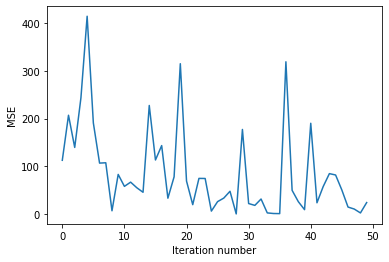

In [15]:
%pylab inline
plot(range(50), mse_er[:50])
xlabel('Iteration number')
ylabel('MSE')

Now let's see how error depends on the iteration number for iterations of stochastic gradient descent. We see that the algorithm converges.

Populating the interactive namespace from numpy and matplotlib


Text(0, 0.5, 'MSE')

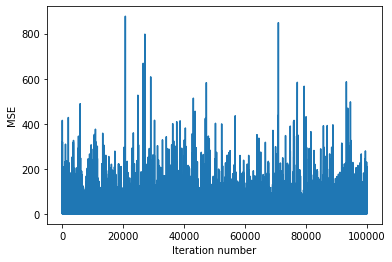

In [16]:
%pylab inline
plot(range(len(mse_er)), mse_er)
xlabel('Iteration number')
ylabel('MSE')

In [17]:
print(f'weight_vector: {w}, \nerror: {mse_er[-1]}')

weight_vector: [13.92595925  2.4988602   4.18726231  2.52440845], 
error: 0.0027459505955991347


In [18]:
y_pred = linear_prediction(X, w)
mserror(y, y_pred)

15.134001595285941